In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from itertools import zip_longest
import os
import matplotlib.pyplot as plt
import seaborn as sns
import ast

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras import layers, models

In [2]:
df = pd.read_csv("All measurements V2, cleaned/all_measurements_summery_30,000_cleaned.csv")

In [3]:
df

,expected_weight,run_index,force_sensor_value,force_vector_1,force_vector_2,force_vector_3,robot_tcp.velocity_linear_1,robot_tcp.velocity_linear_2,robot_tcp.velocity_linear_3,robot_tcp.velocity_angular_1,...,robot_tcp.joint_angles_4,robot_tcp.joint_angles_5,robot_tcp.joint_angles_6,robot_tcp.flange_1,robot_tcp.flange_2,robot_tcp.flange_3,robot_tcp.flange_4,robot_tcp.flange_5,robot_tcp.flange_6,robot_tcp.flange_7
0,0.335,1,0.340568,0.775,-0.453,20.0,0.079766,-0.010370,0.902352,0.000027,...,-2.721707,4.688728,-0.142706,-0.371705,-0.598554,0.068898,0.322016,0.946589,0.014908,-0.007314
1,0.335,1,0.340568,0.785,-0.431,20.0,0.079766,-0.010370,0.902352,0.000027,...,-2.721707,4.688728,-0.142706,-0.371705,-0.598554,0.068898,0.322016,0.946589,0.014908,-0.007314
2,0.335,1,0.341568,0.800,-0.402,20.0,0.153676,-0.044164,0.886970,-0.016157,...,-2.670519,4.689290,-0.137949,-0.371329,-0.598654,0.070673,0.322003,0.946594,0.014877,-0.007324
3,0.335,1,0.341568,0.810,-0.368,20.0,0.153676,-0.044164,0.886970,-0.016157,...,-2.670519,4.689290,-0.137949,-0.371329,-0.598654,0.070673,0.322003,0.946594,0.014877,-0.007324
4,0.335,1,0.342568,0.815,-0.338,19.0,0.156814,-0.048875,0.886929,-0.022112,...,-2.667505,4.689307,-0.137588,-0.371082,-0.598744,0.072457,0.322000,0.946595,0.014853,-0.007342
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15179139,0.482,30973,0.567018,0.190,0.668,16126.0,0.226613,0.411088,0.686115,-0.018644,...,-1.369907,1.565777,4.407333,-0.530585,-0.187143,0.548930,-0.462112,0.886810,0.003469,-0.002924
15179140,0.482,30973,0.568018,0.230,0.691,16322.0,0.226613,0.411088,0.686115,-0.018644,...,-1.369907,1.565777,4.407333,-0.530585,-0.187143,0.548930,-0.462112,0.886810,0.003469,-0.002924
15179141,0.482,30973,0.570018,0.260,0.711,16660.0,0.226613,0.411088,0.686115,-0.018644,...,-1.369907,1.565777,4.407333,-0.530133,-0.186387,0.550307,-0.462154,0.886788,0.003433,-0.002924
15179142,0.482,30973,0.571018,0.284,0.736,16932.0,0.226613,0.411088,0.686115,-0.018644,...,-1.369907,1.565777,4.407333,-0.530133,-0.186387,0.550307,-0.462154,0.886788,0.003433,-0.002924


In [4]:
df.keys()

Index(['expected_weight', 'run_index', 'force_sensor_value', 'force_vector_1',
       'force_vector_2', 'force_vector_3', 'robot_tcp.velocity_linear_1',
       'robot_tcp.velocity_linear_2', 'robot_tcp.velocity_linear_3',
       'robot_tcp.velocity_angular_1', 'robot_tcp.velocity_angular_2',
       'robot_tcp.velocity_angular_3', 'robot_tcp.joint_angles_1',
       'robot_tcp.joint_angles_2', 'robot_tcp.joint_angles_3',
       'robot_tcp.joint_angles_4', 'robot_tcp.joint_angles_5',
       'robot_tcp.joint_angles_6', 'robot_tcp.flange_1', 'robot_tcp.flange_2',
       'robot_tcp.flange_3', 'robot_tcp.flange_4', 'robot_tcp.flange_5',
       'robot_tcp.flange_6', 'robot_tcp.flange_7'],
      dtype='object')

In [5]:
np.random.seed(42)
tf.random.set_seed(42)

LABEL_COL = 'expected_weight'
GROUP_COL = 'run_index'

# all inputs except label and group are treated as time-series features
ts_cols = [c for c in df.columns if c not in [LABEL_COL, GROUP_COL]]

# quick safety check (should be empty)
leaky = set([LABEL_COL, GROUP_COL]) & set(ts_cols)
if leaky:
    raise ValueError(f"These columns must NOT be in ts_cols: {leaky}")

# Use the shortest run length, which is currently 401 ms.
T = int(df.groupby(GROUP_COL).size().min())
print(f'shortest run', T)

def fix_len(x, T):
    """Truncate/pad a 2D array (time, features) to length T with zeros at the end."""
    n = len(x)
    if n >= T:
        return x[:T]
    pad = np.zeros((T - n, x.shape[1]), dtype=x.dtype)
    return np.vstack([x, pad])

X_ts, y, groups = [], [], []
for run_id, g in df.groupby(GROUP_COL, sort=False):
    label = float(g[LABEL_COL].iloc[0])  # constant per run
    ts = g[ts_cols].values.astype('float32')  # (time, num_features)
    ts_fixed = fix_len(ts, T)                 # (T, num_features)
    X_ts.append(ts_fixed)
    y.append(label)
    groups.append(run_id)

X_ts = np.array(X_ts, dtype='float32')    # (num_runs, T, num_features)
y    = np.array(y, dtype='float32')       # (num_runs,)
groups = np.array(groups)

outer = GroupShuffleSplit(test_size=0.25, random_state=42)
tr_idx, te_idx = next(outer.split(X_ts, y, groups=groups))

inner = GroupShuffleSplit(test_size=0.2, random_state=123)
tr2_idx, va_idx = next(inner.split(X_ts[tr_idx], y[tr_idx], groups=groups[tr_idx]))

Xts_tr, Xts_va, Xts_te = X_ts[tr_idx][tr2_idx], X_ts[tr_idx][va_idx], X_ts[te_idx]
y_tr,  y_va,  y_te     = y[tr_idx][tr2_idx],  y[tr_idx][va_idx],  y[te_idx]

print(set(groups[tr_idx][tr2_idx]) & set(groups[tr_idx][va_idx]))
print(set(groups[tr_idx]) & set(groups[te_idx]))

ts_mean = Xts_tr.mean(axis=(0, 1), keepdims=True)
ts_std  = Xts_tr.std(axis=(0, 1), keepdims=True) + 1e-8

Xts_tr = (Xts_tr - ts_mean) / ts_std
Xts_va = (Xts_va - ts_mean) / ts_std
Xts_te = (Xts_te - ts_mean) / ts_std

inp = layers.Input(shape=(T, Xts_tr.shape[-1]), name='ts_in')
x = layers.Conv1D(64, 5, activation='relu', padding='same')(inp)
x = layers.Conv1D(128, 5, activation='relu', padding='same')(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
out = layers.Dense(1, activation=None)(x)

model = models.Model(inp, out)
model.compile(optimizer='adam', loss='mae', metrics=['mae'])
model.summary()

# Train model ===
callbacks = [
    ModelCheckpoint(
        filepath='best_model.h5',      
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=False        
    )
]

history = model.fit(
    Xts_tr, y_tr,
    validation_data=(Xts_va, y_va),
    epochs=50,
    batch_size=40,
    callbacks=callbacks,
    verbose=1
)

# Evaluate on untouched test set ===
best_model = models.load_model('best_model.h5')
y_pred = best_model.predict(Xts_te, verbose=0).ravel()
test_mae = mean_absolute_error(y_te, y_pred)
print(f"Test MAE: {test_mae:.6f}")

shortest run 401
set()
set()
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ts_in (InputLayer)          [(None, 401, 23)]         0         
                                                                 
 conv1d (Conv1D)             (None, 401, 64)           7424      
                                                                 
 conv1d_1 (Conv1D)           (None, 401, 128)          41088     
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                

C:\Users\piete\anaconda3\envs\homl3\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


465/465 [==============================] - 20s 44ms/step - loss: 0.0302 - mae: 0.0302 - val_loss: 0.0217 - val_mae: 0.0217
Epoch 3/50
465/465 [==============================] - 19s 42ms/step - loss: 0.0286 - mae: 0.0286 - val_loss: 0.0211 - val_mae: 0.0211
Epoch 4/50
465/465 [==============================] - 19s 42ms/step - loss: 0.0280 - mae: 0.0280 - val_loss: 0.0180 - val_mae: 0.0180
Epoch 5/50
465/465 [==============================] - 19s 41ms/step - loss: 0.0276 - mae: 0.0276 - val_loss: 0.0180 - val_mae: 0.0180
Epoch 6/50
465/465 [==============================] - 20s 42ms/step - loss: 0.0269 - mae: 0.0269 - val_loss: 0.0178 - val_mae: 0.0178
Epoch 7/50
465/465 [==============================] - 20s 43ms/step - loss: 0.0267 - mae: 0.0267 - val_loss: 0.0172 - val_mae: 0.0172
Epoch 8/50
465/465 [==============================] - 20s 44ms/step - loss: 0.0266 - mae: 0.0266 - val_loss: 0.0210 - val_mae: 0.0210
Epoch 9/50
465/465 [==============================] - 21s 45ms/step - los

In [6]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Compute metrics
r2 = r2_score(y_te, y_pred)
mae = mean_absolute_error(y_te, y_pred)
rmse = mean_squared_error(y_te, y_pred, squared=False)

print(f"R² score: {r2:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")

R² score: 0.9773
MAE: 0.0153
RMSE: 0.0240


In [7]:
# model.save('final_model_try1.keras')

In [9]:
model = load_model('best_model.h5')

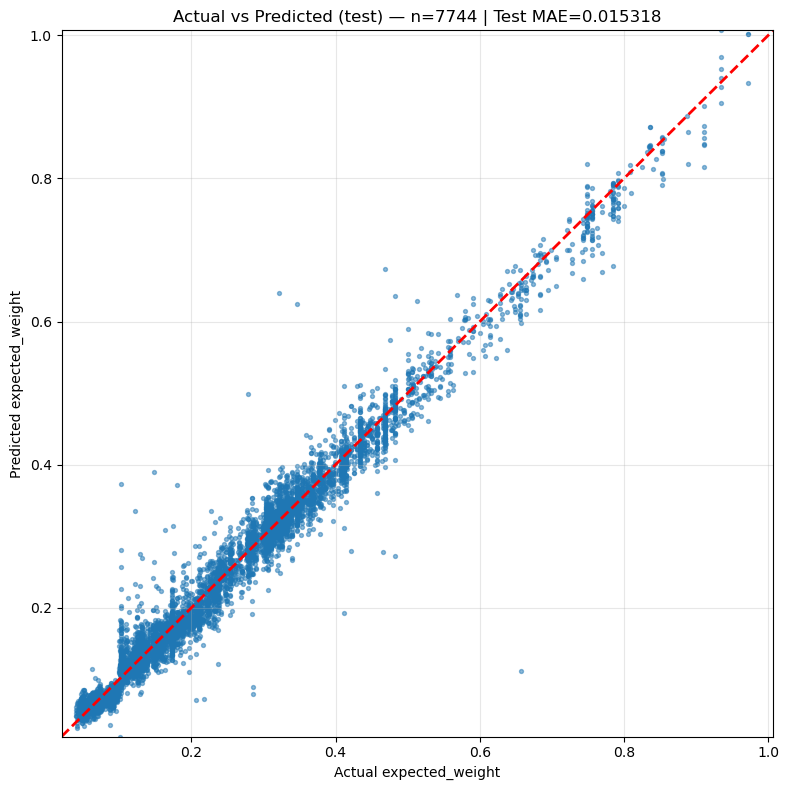

In [13]:
# Ensure 1D arrays
y_true = np.asarray(y_te).ravel()
y_hat  = np.asarray(y_pred).ravel()
assert y_true.shape == y_hat.shape, f"Shape mismatch: {y_true.shape} vs {y_hat.shape}"

# Sample up to 10,000 points for plotting
n_samples = min(10_000, y_true.size)
rng = np.random.default_rng(42)  # reproducible
idx = rng.choice(y_true.size, n_samples, replace=False)

ys = y_true[idx]
ps = y_hat[idx]

# Shared axis limits + 45° reference line
lo = float(min(ys.min(), ps.min()))
hi = float(max(ys.max(), ps.max()))

plt.figure(figsize=(8, 8))
plt.scatter(ys, ps, s=8, alpha=0.5)          # no edgecolor to avoid Matplotlib warning
plt.plot([lo, hi], [lo, hi], 'r--', linewidth=2)
plt.xlim(lo, hi); plt.ylim(lo, hi)
plt.xlabel("Actual expected_weight")
plt.ylabel("Predicted expected_weight")
plt.title(f"Actual vs Predicted (test) — n={n_samples} | Test MAE={test_mae:.6f}")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


Using y_te & y_pred already in memory.
R² score: 0.9773
MAE: 0.0153


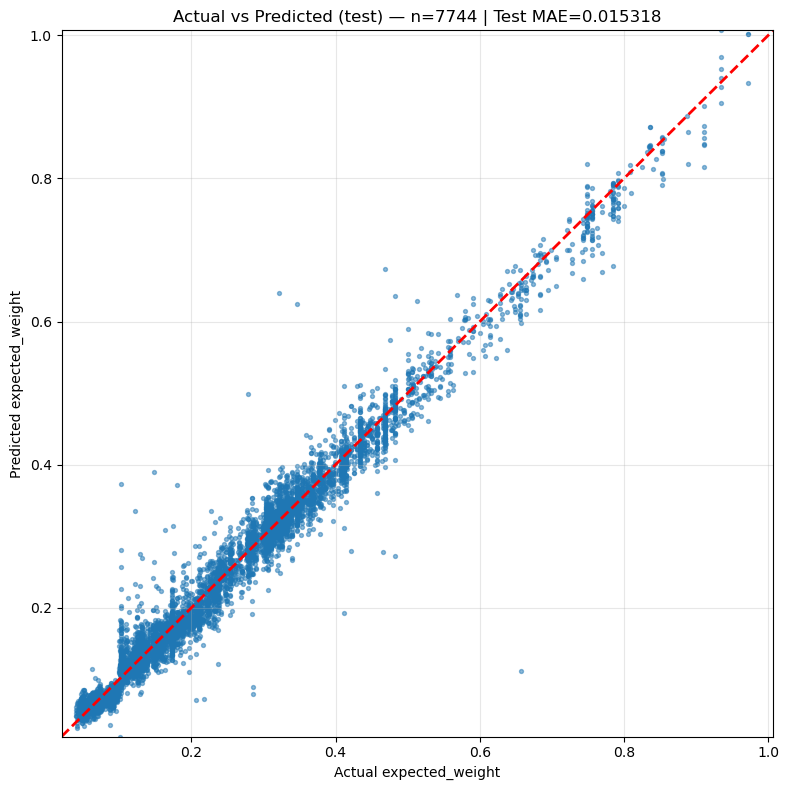

In [14]:
# for loading the model from memory.

assert os.path.exists('best_model.h5'), "Could not find 'best_model.keras' in the working directory."

# --- Try to reuse y_te/y_pred if they already exist ---
need_predictions = False
try:
    _ = y_te
    _ = y_pred
    print("Using y_te & y_pred already in memory.")
except NameError:
    need_predictions = True

if need_predictions:
    # 1) Try to load the fully saved model (.keras usually contains the whole model)
    model = None
    try:
        model = load_model('best_model.keras', compile=False)
        print("Loaded full model from 'best_model.keras'.")
    except Exception as e:
        print("Could not load full model, will try weights-only path.\nReason:", e)
        # If you saved weights only, you must recreate the architecture exactly, then load weights:
        # --- Recreate the architecture (must match your training code) ---
        # You also need T and num_features to define the input shape.
        # We'll infer them from Xts_tr/Xts_te if available; otherwise we rebuild minimal arrays from df.
        try:
            T = Xts_tr.shape[1]
            num_features = Xts_tr.shape[2]
        except NameError:
            # Minimal rebuild to get T/num_features from df
            LABEL_COL, GROUP_COL = 'expected_weight', 'run_index'
            ts_cols = [c for c in df.columns if c not in [LABEL_COL, GROUP_COL]]
            T = int(df.groupby(GROUP_COL).size().min())
            num_features = len(ts_cols)

        inp = layers.Input(shape=(T, num_features), name='ts_in')
        x = layers.Conv1D(64, 5, activation='relu', padding='same')(inp)
        x = layers.Conv1D(128, 5, activation='relu', padding='same')(x)
        x = layers.GlobalAveragePooling1D()(x)
        x = layers.Dense(128, activation='relu')(x)
        x = layers.Dropout(0.5)(x)
        out = layers.Dense(1, activation=None)(x)
        model = models.Model(inp, out)
        model.load_weights('best_model.keras')
        print("Recreated model and loaded weights from 'best_model.keras'.")

    # 2) Ensure we have Xts_te/y_te ready (reuse if present; otherwise minimal rebuild from df)
    try:
        _ = Xts_te; _ = y_te; _ = ts_mean; _ = ts_std  # normalization stats from training
        print("Using Xts_te/y_te already in memory.")
    except NameError:
        print("Rebuilding minimal test set & normalization from df (no retraining).")
        from sklearn.model_selection import GroupShuffleSplit

        LABEL_COL, GROUP_COL = 'expected_weight', 'run_index'
        ts_cols = [c for c in df.columns if c not in [LABEL_COL, GROUP_COL]]

        # fixed sequence length T
        T = int(df.groupby(GROUP_COL).size().min())

        def fix_len(x, T):
            if len(x) >= T:
                return x[:T]
            pad = np.zeros((T - len(x), x.shape[1]), dtype=x.dtype)
            return np.vstack([x, pad])

        # build arrays (one sample per run)
        X_ts, y, groups = [], [], []
        for run_id, g in df.groupby(GROUP_COL, sort=False):
            label = float(g[LABEL_COL].iloc[0])
            ts = g[ts_cols].values.astype('float32')
            X_ts.append(fix_len(ts, T))
            y.append(label)
            groups.append(run_id)

        X_ts = np.array(X_ts, dtype='float32')
        y = np.array(y, dtype='float32')
        groups = np.array(groups)

        # same group-aware splits as training
        outer = GroupShuffleSplit(test_size=0.25, random_state=42)
        tr_idx, te_idx = next(outer.split(X_ts, y, groups=groups))
        inner = GroupShuffleSplit(test_size=0.2, random_state=123)
        tr2_idx, va_idx = next(inner.split(X_ts[tr_idx], y[tr_idx], groups=groups[tr_idx]))

        Xts_tr, Xts_te = X_ts[tr_idx][tr2_idx], X_ts[te_idx]
        y_tr,  y_te     = y[tr_idx][tr2_idx],  y[te_idx]

        # normalize with training-fold stats only
        ts_mean = Xts_tr.mean(axis=(0, 1), keepdims=True)
        ts_std  = Xts_tr.std(axis=(0, 1), keepdims=True) + 1e-8
        Xts_te  = (Xts_te - ts_mean) / ts_std

    # 3) Predict on test set
    y_pred = model.predict(Xts_te, verbose=0).ravel()
    test_mae = mean_absolute_error(y_te, y_pred)
    print(f"Test MAE (recomputed): {test_mae:.6f}")

# --- Metrics you wanted ---
r2  = r2_score(y_te, y_pred)
mae = mean_absolute_error(y_te, y_pred)
print(f"R² score: {r2:.4f}")
print(f"MAE: {mae:.4f}")

# --- Plot you wanted ---
y_true = np.asarray(y_te).ravel()
y_hat  = np.asarray(y_pred).ravel()
assert y_true.shape == y_hat.shape, f"Shape mismatch: {y_true.shape} vs {y_hat.shape}"

n_samples = min(10_000, y_true.size)
rng = np.random.default_rng(42)
idx = rng.choice(y_true.size, n_samples, replace=False)
ys, ps = y_true[idx], y_hat[idx]

lo = float(min(ys.min(), ps.min()))
hi = float(max(ys.max(), ps.max()))

plt.figure(figsize=(8, 8))
plt.scatter(ys, ps, s=8, alpha=0.5)
plt.plot([lo, hi], [lo, hi], '--', linewidth=2, color='red')
plt.xlim(lo, hi); plt.ylim(lo, hi)
plt.xlabel("Actual expected_weight")
plt.ylabel("Predicted expected_weight")
plt.title(f"Actual vs Predicted (test) — n={n_samples} | Test MAE={mae:.6f}")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()